##CARGA DE DATOS DE CITYSCAPES

In [1]:
import tensorflow as tf
import tensorflow_probability as tfp
import cv2
import numpy as np
import itertools
import os
import matplotlib.pyplot as plt
from keras import layers, Model, models, callbacks, applications
from tensorflow_probability import layers as tfp_layers

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
dir = "/content/drive/MyDrive/TFG"
CITYSCAPES_PATH = dir + "/Cityscapes"
IMGS_PATH =  os.path.join(CITYSCAPES_PATH, "leftImg8bit")
MASKS_PATH = os.path.join(CITYSCAPES_PATH, "gtFine")

In [ ]:
#!unzip -q "/content/drive/MyDrive/TFG/leftImg8bit_trainvaltest.zip" -d "/content/drive/MyDrive/TFG/Cityscapes/"
#!unzip -q "/content/drive/MyDrive/TFG/gtFine_trainvaltest.zip" -d "/content/drive/MyDrive/TFG/Cityscapes/"

Clases de píxeles existentes en el dataset, y las 4 con las que nos quedaremos:

In [6]:
data_shape = 256*512  # Nueva resolución de las imágenes (originalmente 1024x2048)
label_colors = {
    "unlabeled": [0, 0, 0],
    "ego vehicle": [0, 0, 0],
    "rectification border": [0, 0, 0],
    "out of roi": [0, 0, 0],
    "static": [0, 0, 0],
    "dynamic": [111, 74,  0],
    "ground": [81,  0, 81],
    "road": [128, 64,128],
    "sidewalk": [244, 35,232],
    "parking": [250,170,160],
    "rail track": [230,150,140],
    "building": [70, 70, 70],
    "wall": [102,102,156],
    "fence": [190,153,153],
    "guard rail": [180,165,180],
    "bridge": [150,100,100],
    "tunnel": [150,120, 90],
    "pole": [153,153,153],
    "polegroup": [153,153,153],
    "traffic light": [153,153,153],
    "traffic sign": [250,170, 30],
    "vegetation": [107,142, 35],
    "terrain": [152,251,152],
    "sky": [70,130,180],
    "person": [220, 20, 60],
    "rider": [255, 0, 0],
    "car": [ 0,  0,142],
    "truck": [0,  0, 70],
    "bus": [ 0, 60,100],
    "caravan": [ 0,  0, 90],
    "trailer": [ 0,  0,110],
    "train": [ 0, 80,100],
    "motorcycle": [0,  0,230],
    "bicycle": [119, 11, 32],
    "license plate": [0,0,142]
}
reduced_label_colors = {
    "background": [46,0,137],  # Azul oscuro
    "vehicle": [255, 255, 0],  # Amarillo
    "person": [255, 0, 0],  # Rojo
    "road": [128, 128, 128]  # Gris
}
num_classes = 4

Métodos auxiliares para el almacenamiento de los datos:

In [ ]:
def one_hot_it2(labels):
    x = np.zeros([256,512,4])
    for i in range(256):
        for j in range(512):
            pixel = tuple(labels[i, j])  # Convertimos el pixel a una tupla para compararlo
            if pixel == tuple(reduced_label_colors["vehicle"]):
                x[i, j, 1] = 1  # Vehículo
            elif pixel == tuple(reduced_label_colors["person"]):
                x[i, j, 2] = 1  # Persona
            elif pixel == tuple(reduced_label_colors["road"]):
                x[i, j, 3] = 1  # Carretera (gris)
            else:
                x[i, j, 0] = 1  # Fondo
    return x
# Normaliza imágenes
def normalized(rgb):
    return rgb/255.0

def resize_image_and_label(img, label, new_height=256, new_width=512):
    # Redimensiona la imagen (interpolación lineal)
    resized_img = cv2.resize(img, (new_width, new_height), interpolation=cv2.INTER_LINEAR)
    # Redimensiona la etiqueta (interpolación nearest neighbor)
    resized_label = cv2.resize(label, (new_width, new_height), interpolation=cv2.INTER_NEAREST)
    return resized_img, resized_label

def map_labels_to_reduced_categories(label):
    new_label = np.zeros((label.shape[0], label.shape[1], 3), dtype=np.uint8)

    # Asignar fondo
    new_label[:, :] = reduced_label_colors["background"]

    # Vehículos (car, truck, bus, caravan, trailer, train, motorcycle, bicycle)
    vehicle_classes = [label_colors["car"], label_colors["truck"], label_colors["bus"],
                       label_colors["caravan"], label_colors["trailer"], label_colors["train"],
                       label_colors["motorcycle"], label_colors["bicycle"]]

    for color in vehicle_classes:
        mask = np.all(label == color, axis=-1)
        new_label[mask] = reduced_label_colors["vehicle"]

    # Personas (person, rider)
    person_classes = [label_colors["person"], label_colors["rider"], label_colors["bicycle"]]

    for color in person_classes:
        mask = np.all(label == color, axis=-1)
        new_label[mask] = reduced_label_colors["person"]

    road_classes = [label_colors["ground"],label_colors["road"]]

    for color in road_classes:
        mask = np.all(label == color, axis=-1)
        new_label[mask] = reduced_label_colors["road"]


    return new_label

Guardamos los datos en el formato que queremos en arrays de numpy

In [ ]:
def load_data(mode, num_imagenes=None, num_cities=None):
    data = []
    label = []
    img_dir = os.path.join(IMGS_PATH, mode)
    label_dir = os.path.join(MASKS_PATH, mode)

    j=0
    # Recorre todas las imágenes
    for city in os.listdir(img_dir):
        city_img_dir = os.path.join(img_dir, city)
        city_label_dir = os.path.join(label_dir, city)
        j=j+1
        if j>num_cities:
          break
        i=0
        for file_name in os.listdir(city_img_dir):
            if file_name.endswith("_leftImg8bit.png"):
                img_path = os.path.join(city_img_dir, file_name)
                label_path = os.path.join(city_label_dir, file_name.replace("_leftImg8bit.png", "_gtFine_color.png"))
                i=i+1
                if i>num_imagenes:
                  break
                # Carga y procesa la imagen y su etiqueta
                img = cv2.imread(img_path)
                lbl =cv2.cvtColor(cv2.imread(label_path), cv2.COLOR_BGR2RGB)

                if img is None:
                    print(f"Error: Could not load image: {img_path}")
                    continue  # Skip this image and go to the next one
                if lbl is None:
                    print(f"Error: Could not load label: {label_path}")
                    continue  # Skip this image and go to the next one

                resized_img, resized_lbl = resize_image_and_label(img, lbl)
                resized_img = normalized(resized_img.astype(np.float32))
                resized_lbl = map_labels_to_reduced_categories(resized_lbl)
                lbl_one_hot = one_hot_it2(resized_lbl)  # Convierte la etiqueta a one-hot

                data.append(resized_img)
                label.append(lbl_one_hot)
                print('.', end='')

    return np.array(data), np.array(label)

In [ ]:
os.makedirs(os.path.join(dir, "data3"), exist_ok=True)
train_data, train_label = load_data("train", 100,15)
train_label = np.reshape(train_label, (len(train_label), data_shape, 4))
np.save("/content/drive/MyDrive/TFG/data3/train_data", train_data)
np.save("/content/drive/MyDrive/TFG/data3/train_label", train_label)

val_data, val_label = load_data("val",50,3)
val_label = np.reshape(val_label, (len(val_label), data_shape, 4))

np.save("/content/drive/MyDrive/TFG/data3/val_data", val_data)
np.save("/content/drive/MyDrive/TFG/data3/val_label", val_label)

test_data, test_label = load_data("test",20,3)
test_label = np.reshape(test_label, (len(test_label), data_shape, 4))

np.save("/content/drive/MyDrive/TFG/data3/test_data", test_data)
np.save("/content/drive/MyDrive/TFG/data3/test_label", test_label)

In [4]:
train_data = np.load('/content/drive/MyDrive/TFG/data3/train_data.npy')
train_label = np.load('/content/drive/MyDrive/TFG/data3/train_label.npy')
val_data = np.load('/content/drive/MyDrive/TFG/data3/val_data.npy')
val_label = np.load('/content/drive/MyDrive/TFG/data3/val_label.npy')
test_data = np.load('/content/drive/MyDrive/TFG/data3/test_data.npy')
test_label = np.load('/content/drive/MyDrive/TFG/data3/test_label.npy')


In [7]:
color_array = np.array(list(reduced_label_colors.values()))

Método que transforma los datos que tenemos almacenados que corresponden a las imágenes etiquetadas para poder visualizarlas:

In [8]:
def visualize(temp, plot=False):
    temp = np.argmax(temp, axis=-1).reshape((256,512))
    r = temp.copy()
    g = temp.copy()
    b = temp.copy()

    for l in range(len(color_array)):
        r[temp == l] = color_array[l, 0]
        g[temp == l] = color_array[l, 1]
        b[temp == l] = color_array[l, 2]

    rgb = np.zeros((temp.shape[0], temp.shape[1], 3))
    rgb[:, :, 0] = r / 255.0
    rgb[:, :, 1] = g / 255.0
    rgb[:, :, 2] = b / 255.0

    if plot:
        plt.imshow(rgb)
    else:
        return rgb

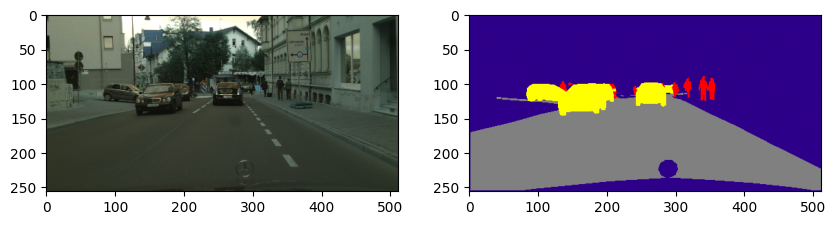

In [9]:
#Veamos la segmentación de la primera imagen del conjunto de entrenamiento:
imagen_rgb_segmentada = visualize(train_label[0])
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(train_data[0])
axs[1].imshow(imagen_rgb_segmentada)
plt.show()